<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Exploratory Data Analysis on a Natural Language Processing Task
> Authors: Caroline Schmitt, Matt Brems

---

Exploratory data analysis (EDA) is a crucial part of any data science project. EDA helps us discover interesting relationships in the data, detect outliers and errors, examine our own assumptions about the data, and prepare for modeling. During EDA we might discover that we need to clean our data more conscientiously, or that we have more missing data than we realized, or that there aren't many patterns in the data (indicating that modeling may be challenging.)

In this lab you'll bring in a natural language dataset and perform EDA. The dataset contains Facebook statuses taken from between 2009 and 2011 as well as personality test results associated with the users whose Facebook statuses are included.

This dataset uses results from the Big Five Personality Test, also referred to as the five-factor model, which measures a person's score on five dimensions of personality:
- **O**penness
- **C**onscientiousness
- **E**xtroversion
- **A**greeableness
- **N**euroticism

Notoriously, the political consulting group Cambridge Analytica claims to have predicted the personalities of Facebook users by using those users' data, with the goal of targeting them with political ads that would be particularly persuasive given their personality type. Cambridge Analytica claims to have considered 32 unique 'groups' in the following fashion:
- For each of the five OCEAN qualities, a user is categorized as either 'yes' or 'no'.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$).

Cambridge Analytica's methodology was then, roughly, the following:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big Five personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

In this lab you will perform EDA to examine many relationships in the data.

Exploratory data analysis can be a non-linear process, and you're encouraged to explore questions that occur to you as you work through the notebook.

> **Content note**: This dataset contains real Facebook statuses scraped from 2009 to 2011, and some of the statuses contain language that is not safe for work, crude, or offensive. The full dataset is available as `mypersonality.csv`, and a sanitized version containing only statuses that passed an automated profanity check is available as `mypersonality_noprofanity.csv`. Please do not hesitate to use `mypersonality_noprofanity.csv` if you would prefer to. Please note that the automated profanity check is not foolproof. If you have any concerns about working with this dataset, please get in touch with your instructional team.

---

### External resources

These resources are not required reading but may be of use or interest.

- [Python Graph Gallery](https://python-graph-gallery.com/)
- [Wikipedia page](https://en.wikipedia.org/wiki/Big_Five_personality_traits) on the Big Five test
- [A short (3-4 pages) academic paper](./celli-al_wcpr13.pdf) using the `MyPersonality` dataset to model personality

---

## Load packages

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

# Imports natural Language for analyze text review
import re
import string

# Warning
import warnings
warnings.filterwarnings("ignore")

# This setting widens how many characters pandas will display 
# in a column:
pd.options.display.max_colwidth = 400

---

## Load data

In [2]:
#df = pd.read_csv('data/mypersonality.csv')

# NOTICE! Do read the commented out code below...
df = pd.read_csv('data/mypersonality_noprofanity.csv') 
# comment out above & 
# uncomment this to use mypersonality_noprofanity.csv if it 
# makes you more comfortable

df.drop(columns=['NETWORKSIZE', 'BETWEENNESS', 'NBETWEENNESS', 
                 'DENSITY', 'BROKERAGE', 'NBROKERAGE', 
                 'TRANSITIVITY'], inplace=True)
df.head(3)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM


In [3]:
# Check shape
df.shape

(9513, 13)

In [4]:
# Check types
df.dtypes

#AUTHID     object
STATUS      object
sEXT       float64
sNEU       float64
sAGR       float64
sCON       float64
sOPN       float64
cEXT        object
cNEU        object
cAGR        object
cCON        object
cOPN        object
DATE        object
dtype: object

In [5]:
# Check missing values
df.isnull().sum()

#AUTHID    0
STATUS     0
sEXT       0
sNEU       0
sAGR       0
sCON       0
sOPN       0
cEXT       0
cNEU       0
cAGR       0
cCON       0
cOPN       0
DATE       0
dtype: int64

---

## EDA on Statuses

Before we even vectorize the text, we might look at the lengths and word counts in each Facebook status.

**Create a new column called `status_length` that contains the length of each status:**

In [6]:
# Create a new column
df["status_length"] = df["STATUS"].apply(len)

In [7]:
# Check
df.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,63
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,121
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/22/09 04:48 AM,42
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/20/09 02:31 AM,11


**Create a new column called `status_word_count` that contains the number of words in each status:**

Note: You can evaluate this based off of how many strings are separated by whitespaces; you're not required to check that each set of characters set apart by whitespaces is a word in the dictionary.

In [8]:
# Create a new column
df["status_word_count"] = df["STATUS"].map(lambda x: len(x.split()))

In [9]:
# Check
df.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27,5
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,63,13
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,121,26
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/22/09 04:48 AM,42,9
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/20/09 02:31 AM,11,3


### Longest and shortest statuses

Looking at individual observations can help us get a sense of what the dataset contains.

**Show the five longest and five shortest statuses based off of `status_word_count`:**

In [10]:
# Five longest in status_word_count columns
# Statues are tell a story 
df.sort_values(by= "status_word_count",ascending=False).head()[["STATUS", "status_word_count"]]

,STATUS,status_word_count
468,"Exact words when renewing DL: Me: Oh no, you can't take my license, It's my 25th b-day. How am I going to get into the bar? DMV: We gonna give you a new one over there Me: But, it won't have my picture and stuff on it. Dmv: Hold up, we can take a picture of your picture and put it on a license i think. (yelling at co-worker to see if this can be done) Yup! Me: So, I can go to the bar?! Dmv: ...",89
4997,"can't believe it. I got the new Wii Fit Plus game, it has a lot of fun new games and features. However, after not using the wii fit for a few months we decided to do the fitness test stuff again. Me(since last time): +2.9 lbs, still a healthy weight and BMI, wii age 54. *PROPNAME*: -8.6lbs, reccommends a healthy weight of gaining 6lbs, wii age 32. On the positive side, I have lost 5 of the 8 l...",84
5457,"I always make it a rule to let the other fellow fire first. If a man wants to fight, I argue the question with him and try to show him how foolish it would be. If he can't be dissuaded, why then the fun begins but I always let him have first crack. Then when I fire, you see, I have the verdict of self-defence on my side. I know that he is pretty certain in his hurry, to miss. I never do.",83
9301,I was totally freaked out tonight while driving home with Janice at 12am. The black coupe next to me matched my speed even though I was going fast and then he continued to match me speed as I slowed down. So I turn to look at the driver of the car and he's wearing a mask. A rubber mask reminiscent to freddy cruger. 0_0 I almost had a heart attack. I then slowed down a lot and he continued on.....,83
9259,"- so, this morning *PROPNAME* gets up to play and he goes over to the carpet where the light was shining through the blinds casting shadows...he then proceeds to tell me the different letters the sun is making on the carpet... 'I', 'T' and 'L' to be exact! He then somehow figured out how to cast his shadow over the sun to make the letters change & disappear! At this rate, he will be smarter th...",82


In [11]:
# Five shortest in status_word_count columns
# Some statues are link two words(note use space to divide word)
# Some statues are the language change
df.sort_values(by= "status_word_count",ascending=False).tail()[["STATUS", "status_word_count"]]

,STATUS,status_word_count
5607,busy...always,1
472,Thanksgiving!,1
761,jahvid!,1
7768,MEHHHHHHHHHHHHHHHHHHURRRRRGHHHHHHHH.....,1
2015,Headache,1


## What's the distribution of post lengths?

Use visuals to show the distributions of post lengths. Show both the distribution of word counts and the distribution of lengths based off character.

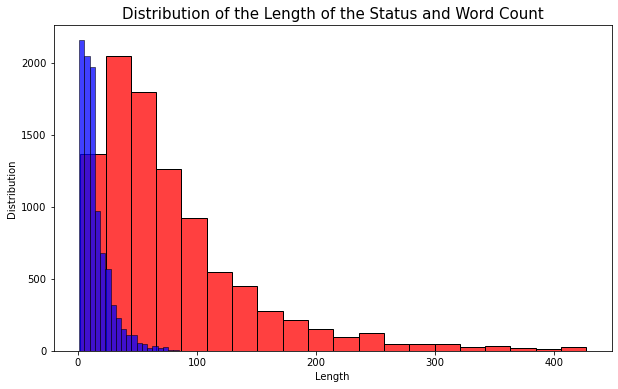

In [12]:
# Create distribution graph of status_length and status_word_count
# Both distribution graph are very right skew and same likely each other
plt.figure(figsize = (10, 6))
sns.histplot(df['status_length'], bins = 20, color = 'r') # counts space and word
sns.histplot(df['status_word_count'], bins = 20, color = 'b') # counts only word
plt.xlabel('Length', size = 10)
plt.ylabel('Distribution', size= 10)
plt.title('Distribution of the Length of the Status and Word Count', size = 15);

In [13]:
# Show skew of status_length
df['status_length'].skew()

1.9369114143903716

In [14]:
# Show skew of status_word_count
df['status_word_count'].skew()

1.9570948044583552

---

## EDA of Personality Scores

There are two sets of personality columns in the dataset: class and score. According to the attached paper, scores have been converted to categories based on whether a score for a user fell above or below the median.

### Plot the distributions of personality scores for all five score columns:

Skew value of sEXT : -0.24
Skew value of sNEU : 0.43
Skew value of sAGR : -0.13
Skew value of sCON : -0.09
Skew value of sOPN : -1.05


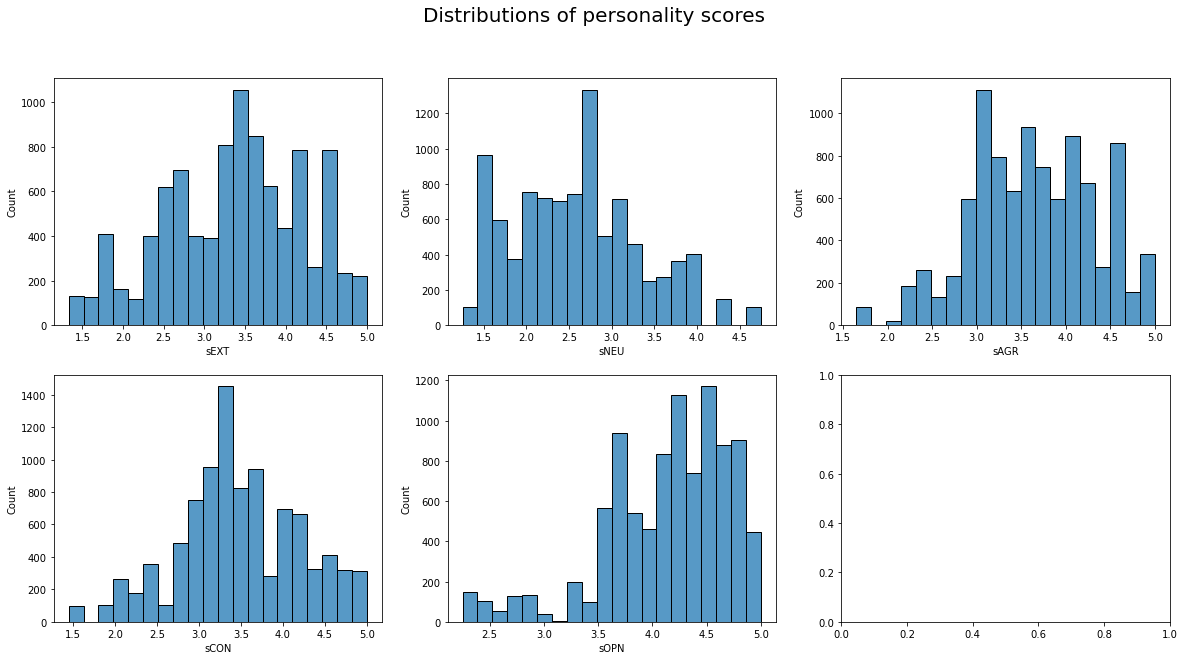

In [15]:
# Distributions of personality scores
# Mostly a score for a user feel free to select the median(bias)
# therefore scores have been converted to categories
# Fortunately we have Personality class 
num_columns = ['sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN']
fig, axes = plt.subplots(2,3,figsize=(20,10))
fig.suptitle("Distributions of personality scores", fontsize=20)
for i, feat in enumerate(num_columns):
    x = i // 3  
    y = i % 3  
    sns.histplot(ax=axes[x,y], x=df[feat], bins = 20)
    print(f"Skew value of {feat} : {round(df[feat].skew(),2)}")

In [16]:
# Check values in personality class
cat_columns = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']
for i in cat_columns:
    print(df[i].value_counts())

n    5437
y    4076
Name: cEXT, dtype: int64
n    6001
y    3512
Name: cNEU, dtype: int64
y    5100
n    4413
Name: cAGR, dtype: int64
n    5090
y    4423
Name: cCON, dtype: int64
y    7099
n    2414
Name: cOPN, dtype: int64


In [17]:
# Convert to binary values
dict_binary = {"n":1, "y":0}
for i in cat_columns:
    df[i] = df[i].map(dict_binary)

In [18]:
df.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,1,0,1,1,0,06/19/09 03:21 PM,27,5
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,1,0,1,1,0,07/02/09 08:41 AM,63,13
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,1,0,1,1,0,06/15/09 01:15 PM,121,26
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,1,0,1,1,0,06/22/09 04:48 AM,42,9
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,1,0,1,1,0,07/20/09 02:31 AM,11,3


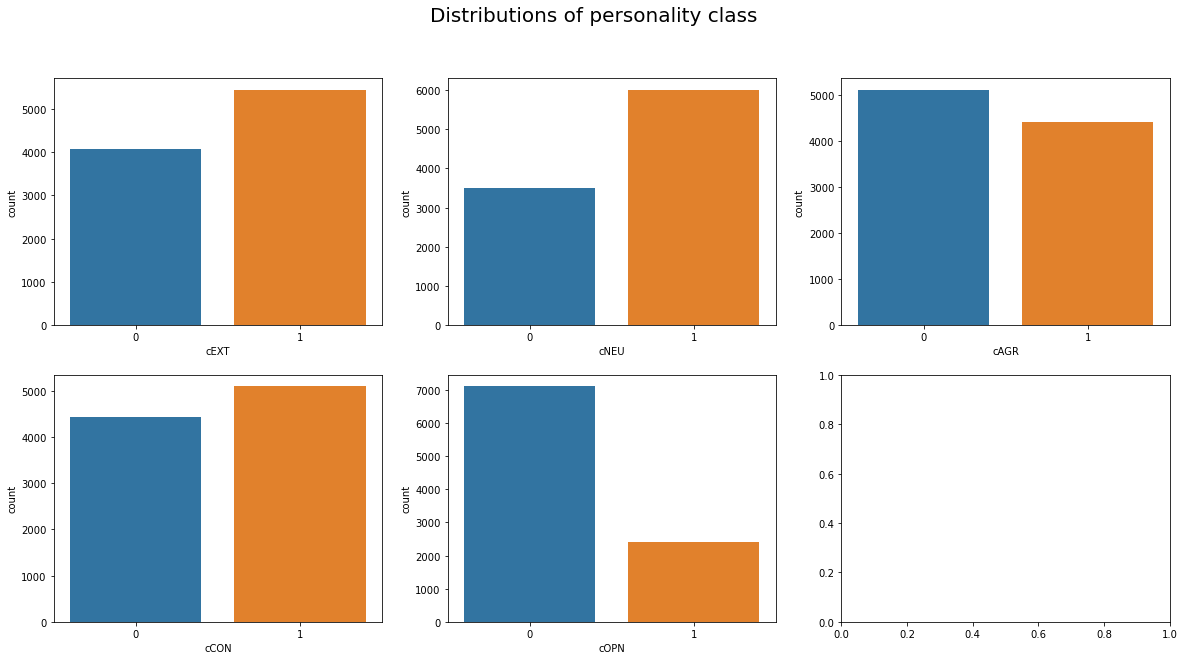

In [19]:
# Create count plot of each personality class columns
# Extraversion/Neuroticism/Conscientiousness personality belongs to the majority
# Openness/Agreeablness personality belongs to the minority
# Good for train the model to predict personality  
fig, axes = plt.subplots(2,3,figsize=(20,10))
fig.suptitle("Distributions of personality class", fontsize=20)
for i, feat in enumerate(cat_columns):
    x = i // 3  
    y = i % 3  
    sns.countplot(ax=axes[x,y],x=df[feat])

---

### How many unique users exist in the dataset?

This dataset has redacted original poster names, but each user is given an `#AUTHID`. How many unique users are there, and how many posts per user do we have?

In [20]:
print(f"We have {len(df['#AUTHID'].unique())} unique users")

We have 250 unique users


In [21]:
# We have the most posts per user 219 posts
df['#AUTHID'].value_counts()

6f2bebc01062eb8334dccba3e048fdb5    219
e6cdef6f475cce3023c5b715f8c9f110    193
527ed53d2ba3a3bc417b8402d5b2f556    178
0737e4e4980f56c9fb1cb5743001c917    171
502db2fcfe26705ae16a46c5cb2ad2e5    161
                                   ... 
00419a4c96b32cd63b2c7196da761274      1
19c6d69f9f5acc1a43d6ac498085e69f      1
ac8bf16a381d07c01b11651994ecb746      1
22d1f7b24168528163c515b1c96a879c      1
a286b7286b1247d4a7851709e9f31e1e      1
Name: #AUTHID, Length: 250, dtype: int64

## EDA on unique users

Because we have many posts per user for most users, doing EDA on the personality score columns might be misleading. If we have 200 Facebook statuses from one very high-conscientiousness user, a bar chart of how many `'cCON'` statuses are associated with `'y'` might be misleading. We'll have to be careful about labeling and titling any visualizations we make off of the dataset.

**Create a new dataframe called `unique_users` that only contains the `#AUTHID`, personality score, and personality category columns:**

If you do this correctly, it should have 250 rows and 11 columns.

(Hint: You can use the pandas [drop_duplicates()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) method to make this easier. The only column you want to consider when deciding if a user is duplicated is the `#AUTHID` column.)

In [22]:
unique_users = df.drop(columns=["STATUS","DATE","status_length","status_word_count"]).drop_duplicates()
unique_users

,#AUTHID,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN
0,b7b7764cfa1c523e4e93ab2a79a946c4,2.65,3.00,3.15,3.25,4.40,1,0,1,1,0
101,318bf822d4f2bd3920367560218619c0,4.50,4.00,3.00,4.50,3.75,0,0,1,0,1
166,ecbddbfe00e0f83cfdb802a7186061c7,4.30,2.15,3.60,3.30,4.10,0,1,0,1,0
229,db39f7b2aad360b1033ec1f8fcd57f9c,4.65,3.20,3.05,3.65,4.75,0,0,1,0,0
238,4d035bd3fd8d9595d15cea9e388964be,3.70,2.90,3.40,3.35,4.05,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
9506,a764ca41dca158d7a191505dcc8ce47f,3.70,2.50,4.20,4.10,3.60,0,1,0,0,1
9507,deb899e426c1a5c66c24eeb0d7df6257,2.15,2.15,4.10,2.90,4.60,1,1,0,1,0
9509,ea28a927cb6663480ea33ca917c3c8ba,4.05,3.35,3.80,3.95,4.50,0,0,0,0,0
9511,5532642937eb3497a43e15dbb23a9d2d,1.40,4.05,3.30,3.40,3.95,1,0,1,1,0


**Plot the distribution of personality scores for `unique_users`:**

Do the distributions look different? Here, each individual user will only be represented once.

**Use the `.describe()` method on `unique_users`:**

In [23]:
unique_users[num_columns].describe()

,sEXT,sNEU,sAGR,sCON,sOPN
count,250.000000,250.000000,250.000000,250.000000,250.00000
mean,3.292120,2.627240,3.600320,3.522920,4.07856
std,0.861368,0.776835,0.670758,0.740211,0.57506
min,1.330000,1.250000,1.650000,1.450000,2.25000
25%,2.662500,2.000000,3.150000,3.000000,3.75000
50%,3.300000,2.590000,3.660000,3.500000,4.15000
75%,4.000000,3.150000,4.100000,4.050000,4.50000
max,5.000000,4.750000,5.000000,5.000000,5.00000


Skew value of sEXT : -0.1
Skew value of sNEU : 0.41
Skew value of sAGR : -0.29
Skew value of sCON : -0.17
Skew value of sOPN : -0.78


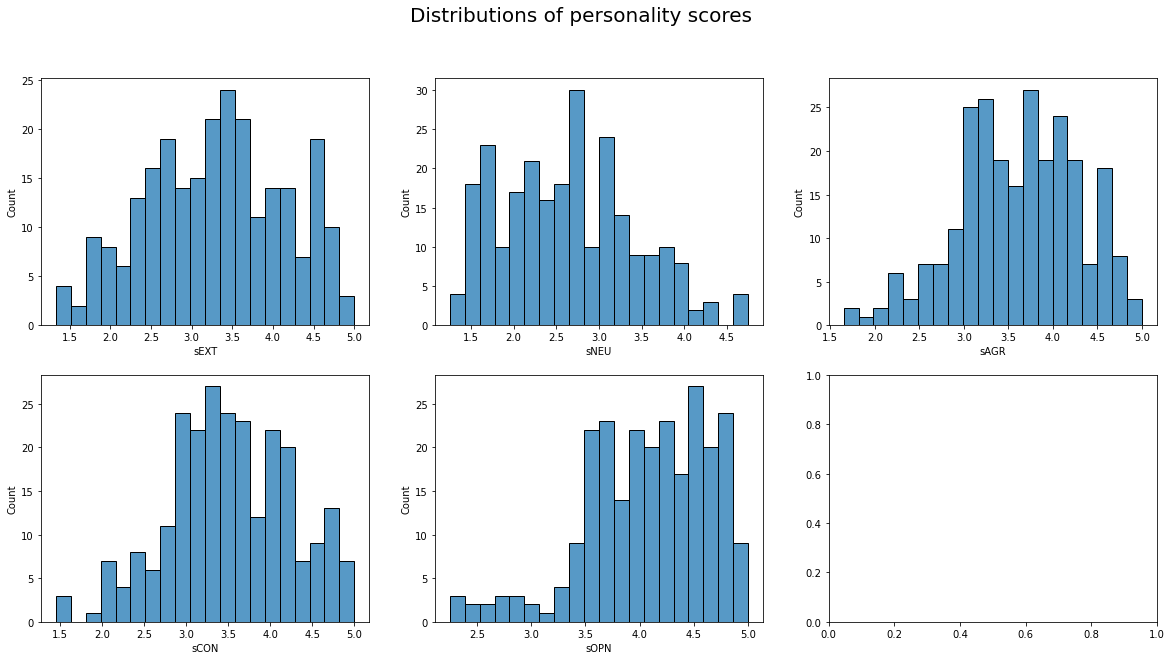

In [24]:
# Skew value old/new 
# Skew value of sEXT : -0.24/-0.1 --> increase 
# Skew value of sNEU : 0.43/0.41 --> decrease
# Skew value of sAGR : -0.13/-0.29 --> decrease
# Skew value of sCON : -0.09/-0.17 --> decrease
# Skew value of sOPN : -1.05/-0.78  --> increase 
# slightly look different between before and after unique_users but don't change skew type
num_columns = ['sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN']
fig, axes = plt.subplots(2,3,figsize=(20,10))
fig.suptitle("Distributions of personality scores", fontsize=20)
for i, feat in enumerate(num_columns):
    x = i // 3  
    y = i % 3  
    sns.histplot(ax=axes[x,y], x=unique_users[feat], bins = 20)
    print(f"Skew value of {feat} : {round(unique_users[feat].skew(),2)}")

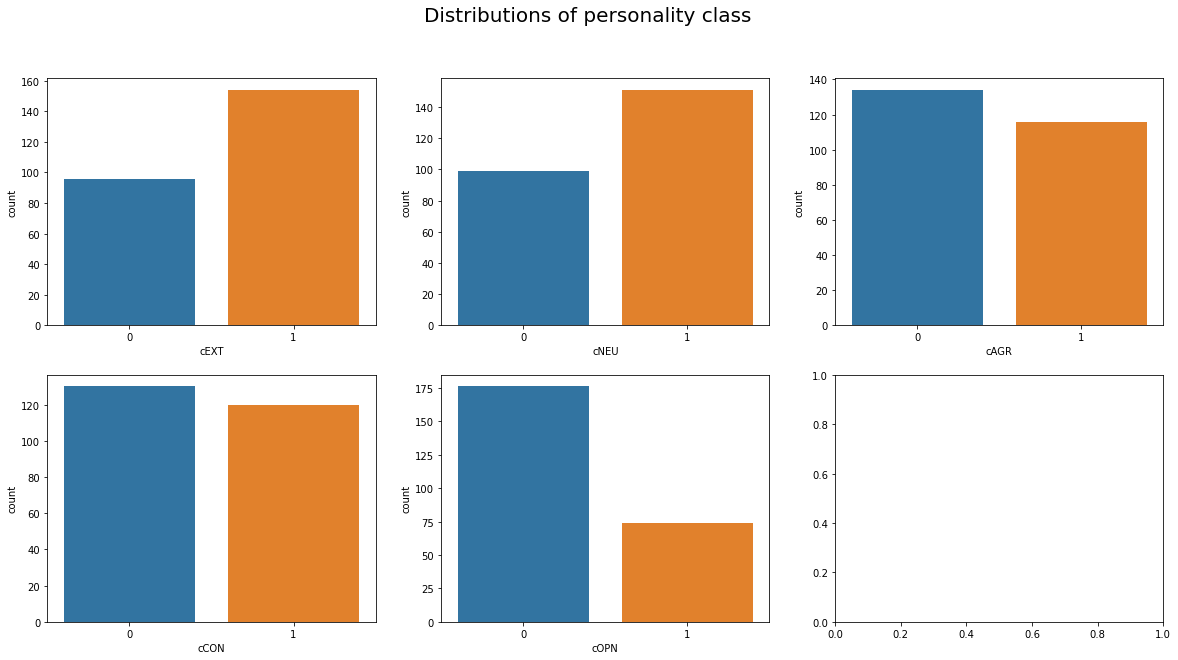

In [25]:
# Not look different between before and after unique_users
fig, axes = plt.subplots(2,3,figsize=(20,10))
fig.suptitle("Distributions of personality class", fontsize=20)
for i, feat in enumerate(cat_columns):
    x = i // 3  
    y = i % 3  
    sns.countplot(ax=axes[x,y],x=unique_users[feat])

### Plots vs. Tables

Consider what different information is easily conveyed by the plots of scores, versus the table with summary statistics. Explain when you might present a distribution versus when you might present a table of summary statistics.

I would display a distribution plot when a high-level overview sufficiently conveys enough. A table would be best when we need exact numbers that the graph cannot give us.

#### Other visualizations:

Create 1-2 additional visualizations related to the `unique_users` dataframe.

You might consider:
- Bar charts of users per category per trait
- Seaborn correlation heatmap
- Seaborn pairplot

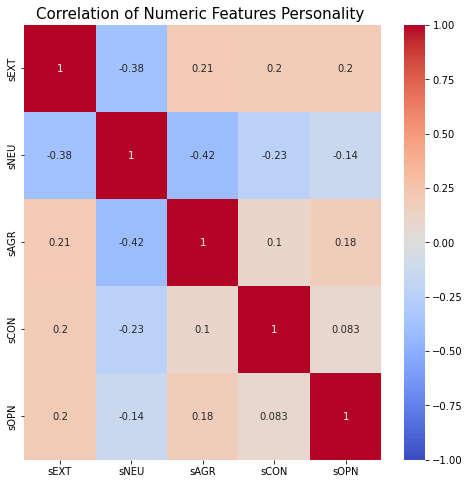

In [26]:
# Seaborn correlation heatmap numeric features
plt.figure(figsize=(8,8))
sns.heatmap(unique_users[num_columns].corr(),annot=True, \
            cmap='coolwarm', vmin=-1, vmax=1)
plt.title(label='Correlation of Numeric Features Personality ', fontsize=15);

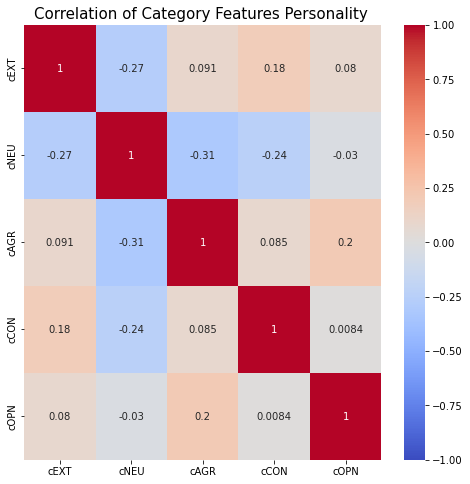

In [27]:
# Seaborn correlation heatmap category features
plt.figure(figsize=(8,8))
sns.heatmap(unique_users[cat_columns].corr(),annot=True, \
            cmap='coolwarm', vmin=-1, vmax=1)
plt.title(label='Correlation of Category Features Personality ', fontsize=15);

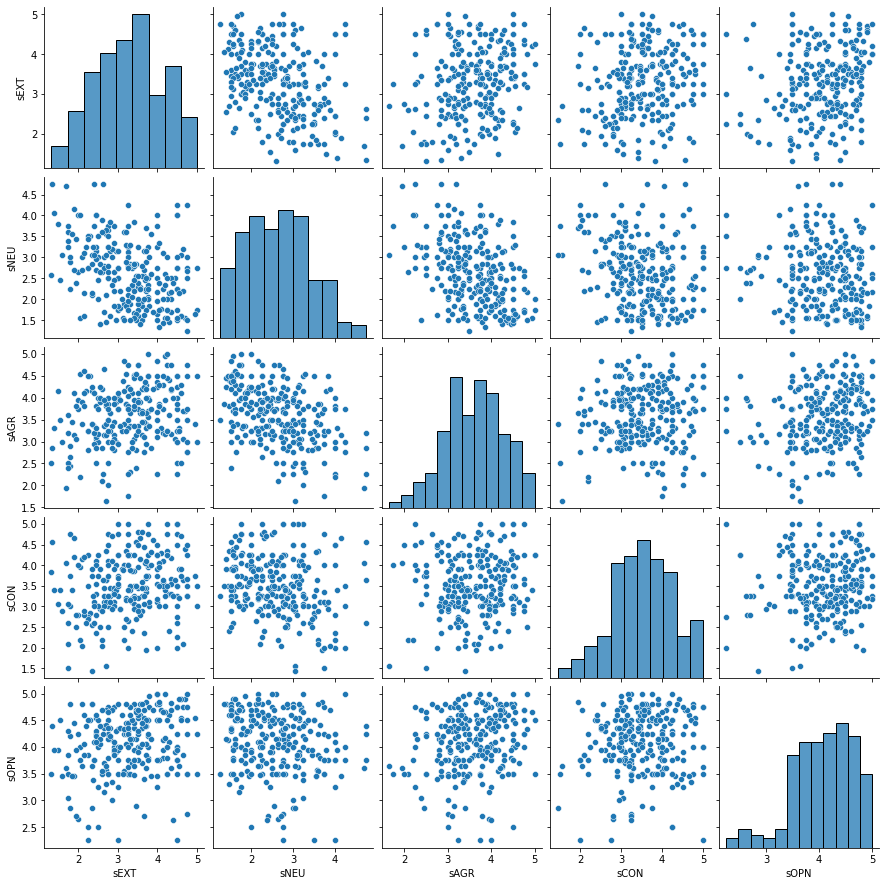

In [28]:
# Seaborn pairplot numeric features
sns.pairplot(unique_users[num_columns]);

---

## Exploring status length and word count based on personality

**Using `groupby()`, find the mean status length and status word count for posts by users in the high and low categories of each of the Big 5 traits.**

You'll need to use `groupby()` five separate times for this.

In [29]:
# Groupby() of each category features
for i in cat_columns:
    print("------------------------------------------------------------")
    print(df.groupby(i)[["status_length", "status_word_count"]].mean())

------------------------------------------------------------
      status_length  status_word_count
cEXT                                  
0         80.755888          14.515456
1         77.500276          13.965054
------------------------------------------------------------
      status_length  status_word_count
cNEU                                  
0         77.139522          13.910877
1         79.922680          14.370605
------------------------------------------------------------
      status_length  status_word_count
cAGR                                  
0         79.187647          14.224510
1         78.557217          14.173578
------------------------------------------------------------
      status_length  status_word_count
cCON                                  
0         78.197603          14.113724
1         79.501375          14.276621
------------------------------------------------------------
      status_length  status_word_count
cOPN                            

**Choose one of the personality category columns (i.e. `cOPN`, `cCON`, `cEXT`, `cAGR`, or `cNEU`.) Use `sns.distplot()` to visualize the distribution of status word counts for posts by users who score both high (`y`) and low (`n`) in that personality category:**

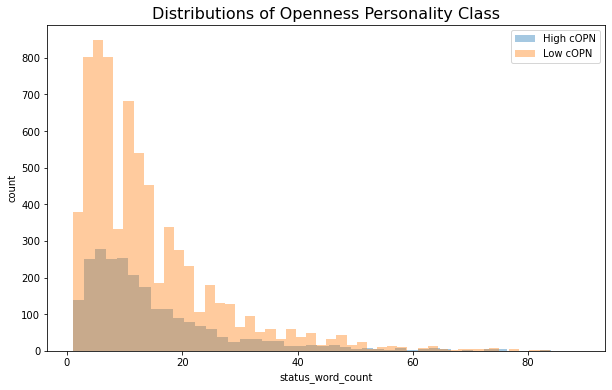

In [30]:
# Distribution plot cOPN columns of status_word_count
plt.figure(figsize = (10, 6))
sns.distplot(df[df["cOPN"] ==1]["status_word_count"],kde=False, label="High cOPN")
sns.distplot(df[df["cOPN"] ==0]["status_word_count"],kde=False, label="Low cOPN")
plt.ylabel("count")
plt.title("Distributions of Openness Personality Class", size=16)
plt.legend();

---

## EDA on Word Counts

### Vectorize the text

In order to perform EDA on word count data, we'll need to count-vectorize.

Create a dataframe that contains the count-vectorized text for each Facebook status in the dataset.

To do this, you might follow these steps:
- Instantiate a `CountVectorizer` object
- Fit the count vectorizer on the Facebook statuses
- Store the transformed data
- Convert to a dataframe and store
    - Don't forget that the transformed data will need to be 'densified'. The `toarray()` or `todense()` methods will allow this.
    - Don't forget that the `get_feature_names()` method on a fitted `CountVectorizer` object will bring you back the words learned from the dataset, which you can set as the `columns` argument when creating the dataframe.
    
It's up to you whether or not to keep stopwords in the dataset.

In [31]:
# Instantiate a CountVectorizer
cvec = CountVectorizer(stop_words="english")

# Define X
X = df["STATUS"]

# Fit the vectorizer on our corpus (all of rows of text)
cvec.fit(X)

# Transform the corpus
X = cvec.transform(X)

In [32]:
# Convert to a dataframe
df_cvev = pd.DataFrame(X.todense(), 
                        columns=cvec.get_feature_names_out())
df_cvev

,00,000,000ft,00am,00pm,01,02,02pm,03,0330,...,zzz,zzzz,zzzzz,zzzzzzzzzzzz,zzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzz,âºâ,ãªtre,ãºltimas,ãºltimos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9509,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9510,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9511,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Show the 15 most common words

In [33]:
# Show
df_cvev.sum().sort_values(ascending=False).head(15)

propname    1247
just         670
day          512
like         459
time         408
going        392
today        387
new          374
work         358
good         339
night        300
got          293
love         275
happy        267
tomorrow     263
dtype: int64

### Show the 15 frequency of the most common words as a bar chart

**Hint**: You can do this in one line of code. [This webpage](https://dfrieds.com/data-visualizations/bar-plot-python-pandas.html) has an example.

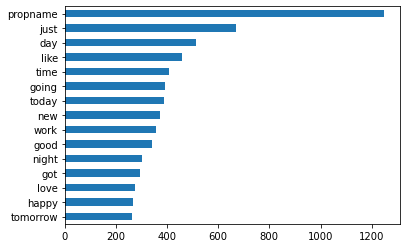

In [34]:
# Plor bar chart
df_cvev.sum().sort_values(ascending=True).tail(15).plot(kind='barh');

### Investigating `propname`

The word `propname` shows up frequently in this dataset. Show the first 10 statuses in the dataset that contain `propname`:

**Provide a short explanation of what you believe `propname` to be:**

In [35]:
# anonymized manually, with each proper name 
# replaced by a fixed string (*PROPNAME*),
# though famous named entities
# https://github.com/nlp-psych/personality
df.iloc[df_cvev["propname"].sort_values(ascending=False).head(10).index][["STATUS"]]

,STATUS
4883,"went white water rafting today for the first time in 10 years...since senior trip at WBC! Thought of you Wilshire friends - *PROPNAME*, *PROPNAME*, *PROPNAME*, *PROPNAME*, *PROPNAME* *PROPNAME*, *PROPNAME*, *PROPNAME*, *PROPNAME*, *PROPNAME*..."
4092,"Sorry, People magazine... your ""sexy"" guys can't hold a candle to the men of the 40s, 50s and 60s... *PROPNAME*, *PROPNAME*, *PROPNAME*, *PROPNAME*, *PROPNAME*, *PROPNAME*, *PROPNAME*, *PROPNAME*, *PROPNAME*..."
4516,"thinks she must say her name strangle when answering the phone at work, as most ppl hear (*PROPNAME*, *PROPNAME*, *PROPNAME*, *PROPNAME*, *PROPNAME*, and *PROPNAME*)...I am not sure how they get that from ""*PROPNAME* speaking"" lol but it is funny to be called *PROPNAME* and *PROPNAME*??? Crazy day lol"
5010,"The feminine version of the name *PROPNAME* meaning ""the woman."" Basically never printed on magnets, mugs or other souvenir paraphernalia. Often mistaken for *PROPNAME*, *PROPNAME*, *PROPNAME*, *PROPNAME* or *PROPNAME*. My name is *PROPNAME*, not *PROPNAME*, dammit. (Urbandictionary.com, type in your first name, copy and paste the first entry)"
4836,"thinks tomorrow with *PROPNAME*, *PROPNAME*, *PROPNAME*, *PROPNAME*, *PROPNAME* ? and *PROPNAME* is gunna be jokes at Dancin Dragon ;)"
6763,"has a big bet on the WSOP final table... I bet on *PROPNAME* to win vs *PROPNAME* to win against *PROPNAME*. Any other winners is a tie. I figure *PROPNAME* is about 3:1 & *PROPNAME* is about 7.5:1 I loooove my bet right now (no odds!) I wanted to book more action last night vs *PROPNAME* when I saw him at the Bellagio, but he doesn't like his side anymore. Ship the EV kidd!!!!!"
4882,welcomes *PROPNAME* into the world! Congratulations *PROPNAME* and *PROPNAME* and *PROPNAME* and *PROPNAME*!
1275,"has two kittens! The girl is *PROPNAME* and I need help with the boy... it's between *PROPNAME*, *PROPNAME*, *PROPNAME*, and *PROPNAME*. VOTE!"
6530,"No wonder *PROPNAME* *PROPNAME* *PROPNAME* dumped *PROPNAME*. His song about her is HORRENDOUS, even for a 90s ballad. Now I understand that *PROPNAME* is a (marginal) step up for her. *Shudder*"
7464,"congrats to *PROPNAME* and *PROPNAME*. *PROPNAME* has a new little baby niece, *PROPNAME*!! (She'll be mine, too, shortly!!)"


## Most common words based on personality category

In order to do more targeted EDA, we'll need to be able to reference not only the dataframe of vectorized statuses, but also the personality scores from the original dataframe.

**Create a new dataframe called `text_and_scores` that concatenates the count-vectorized statuses side-by-side with the original personality category columns:**

In [36]:
# Create a new dataframe 
text_and_scores = df_cvev.join(df[cat_columns])
text_and_scores.head()

,00,000,000ft,00am,00pm,01,02,02pm,03,0330,...,zzzzzzzzzzzzzzzzzzzzzzzzz,âºâ,ãªtre,ãºltimas,ãºltimos,cEXT,cNEU,cAGR,cCON,cOPN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0


**Show the 25 most common words for statuses from high-cAGR users:**

In [37]:
# Show
text_and_scores[text_and_scores["cAGR"]==1][cvec.get_feature_names_out()].sum().sort_values(ascending=False).head(25)

propname    579
just        285
day         222
going       202
like        200
time        197
new         184
today       174
work        157
good        145
night       144
got         143
home        130
tonight     123
tomorrow    113
life        113
really      112
love        112
know        111
don         111
happy       103
think       101
people       99
want         98
week         96
dtype: int64

**Show the 25 most common words for statuses from low-cAGR users:**

In [38]:
# Show
text_and_scores[text_and_scores["cAGR"]==0][cvec.get_feature_names_out()].sum().sort_values(ascending=False).head(25)

propname    668
just        385
day         290
like        259
today       213
time        211
work        201
good        194
new         190
going       190
happy       164
love        163
night       156
got         150
tomorrow    150
know        147
people      139
life        131
tonight     127
home        123
really      119
don         108
weekend     104
want        102
ll           98
dtype: int64

### (BONUS) Most common bigrams:

This is a bonus section and not required (**_though highly recommended_**).

Find the 10 most common [bigrams](https://en.wikipedia.org/wiki/Bigram) in the dataset.

In [39]:
# Instantiate, fix and transform a CountVectorizer (bigrams)
cvec_bi = CountVectorizer(stop_words="english", ngram_range=(2,2))
cvec_bi.fit(df["STATUS"])
X = cvec_bi.transform(df["STATUS"])

In [40]:
# Create dataframe
df_cvev_bi = pd.DataFrame(X.todense(), 
                        columns=cvec_bi.get_feature_names_out())
df_cvev_bi.head()

,00 00,00 01,00 300,00 58,00 bills,00 friday,00 glee,00 gotta,00 min,00 outside,...,zynga games,zynga mafia,zynga yes,âºâ australia,âºâ pass,âºâ âºâ,ãªtre apprã,ãªtre quoi,ãºltimas hojas,ãºltimos dã
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# Show 10 most common bigrams
df_cvev_bi.sum().sort_values(ascending=False).head(10)

propname propname    144
just got              54
new year              52
http www              44
merry christmas       44
looking forward       43
feel like             34
happy new             32
birthday wishes       29
don know              29
dtype: int64

### (BONUS) Most common trigrams:

This is a bonus section and not required (**_though highly recommended_**).

Find the 10 most common [trigrams](https://en.wikipedia.org/wiki/Trigram) in the dataset.

In [42]:
# Instantiate, fix and transform a CountVectorizer (trigrams)
cvec_tri = CountVectorizer(stop_words="english", ngram_range=(3,3))
cvec_tri.fit(df["STATUS"])
X = cvec_tri.transform(df["STATUS"])

In [43]:
# Create dataframe
df_cvev_tri = pd.DataFrame(X.todense(), 
                        columns=cvec_tri.get_feature_names_out())
df_cvev_tri.head()

,00 00 300,00 00 today,00 01 wddw,00 300 mins,00 58 midnight,00 bills op,00 friday nights,00 glee doesn,00 gotta love,00 min entire,...,zynga yes zynga,âºâ australia day,âºâ pass âºâ,âºâ âºâ australia,âºâ âºâ pass,âºâ âºâ âºâ,ãªtre apprã ciã,ãªtre quoi ce,ãºltimas hojas pero,ãºltimos dã en
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# Show 10 most common trigrams
df_cvev_tri.sum().sort_values(ascending=False).head(10)

propname propname propname    54
film industry examiner        23
gainesville film industry     23
24676 gainesville film        23
www examiner com              23
http www examiner             23
happy new year                21
com examiner 24676            20
examiner com examiner         20
examiner 24676 gainesville    20
dtype: int64

---

## Choose your own adventure

By now you've looked at a lot of visualizations and frequency counts.

Come up with 2-3 questions about the data, and try to answer them using descriptive statistics (like counts, averages, etc.) or visualizations.

Some questions you might explore:
- Have numbers been redacted, or are phone numbers, house numbers, or zip codes anywhere in the dataset?
- `PROPNAME` has been used to redact personal names. Given that this data was scraped between 2009 and 2011, investigate if any public figures or famous people show up in the dataset, or their names have been redacted as well.
- Is count of uppercase letters vs. lowercase letters per status related to any personality category or personality score?
- Is _average_ word count per status related to any personality category or personality metric?
- Is punctuation use related to personality?

Or, of course, come up with your own questions to investigate!

The focus here is on "explore" -- you might not find anything of particular interest, but don't let that discourage you.

### Is _average_ word count per status related to any personality category or personality metric?

In [45]:
# Groupby() of each category features
for i in cat_columns:
    print("------------------------------------------------------------")
    print(df.groupby(i)[["status_word_count"]].mean())

------------------------------------------------------------
      status_word_count
cEXT                   
0             14.515456
1             13.965054
------------------------------------------------------------
      status_word_count
cNEU                   
0             13.910877
1             14.370605
------------------------------------------------------------
      status_word_count
cAGR                   
0             14.224510
1             14.173578
------------------------------------------------------------
      status_word_count
cCON                   
0             14.113724
1             14.276621
------------------------------------------------------------
      status_word_count
cOPN                   
0             14.020566
1             14.731152


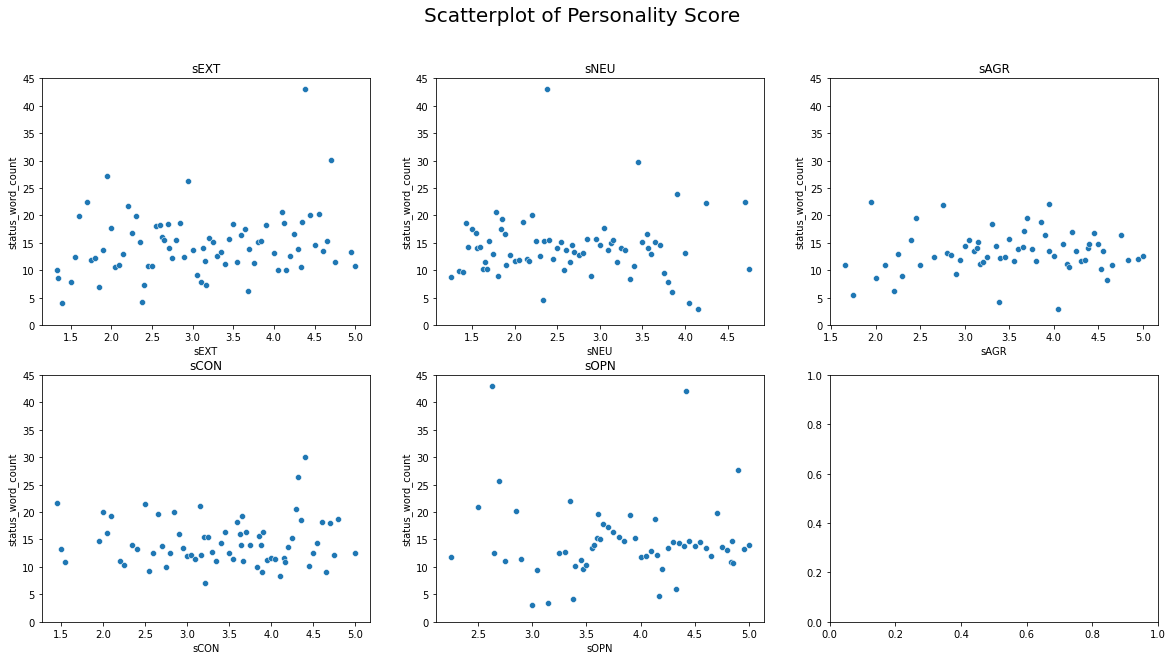

In [46]:
# Groupby() of each numerical features
# Show graph mean of each numerical features
fig, ax = plt.subplots(2,3,figsize=(20,10))
fig.suptitle("Scatterplot of Personality Score", fontsize=20)
for i, feat in enumerate(num_columns):
    x = i // 3  
    y = i % 3
    z = i
    graph_z = sns.scatterplot(ax=ax[x,y], x=feat,y='status_word_count',
    data=df.groupby(feat)[["status_word_count"]].mean())
    graph_z.set(ylim=(0, 45))
    graph_z.set(title=feat)

The average word count for status does not relate to any personality category and numerical(score).

### Is punctuation use related to personality?

In [47]:
# Create function to count punctuation
def review_cleaning(text):
    count = re.findall('[%s]' % re.escape(string.punctuation), text)
    return len(count)

In [48]:
# Use function in STATUS column to count punctuation 
# And save in punctuation column
df["punctuation"] = df["STATUS"].map(review_cleaning)
df[["STATUS","punctuation"]].head()

,STATUS,punctuation
0,likes the sound of thunder.,1
1,is so sleepy it's not even funny that's she can't get to sleep.,4
2,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",5
3,likes how the day sounds in this new song.,1
4,is home. <3,2


In [49]:
# Show mean punctuation of each personality class
# The average punctuation count for status 
# does not relate to any personality category
for i in cat_columns:
    print("------------------------------------------------------------")
    print(df.groupby(i)[["punctuation"]].mean())

------------------------------------------------------------
      punctuation
cEXT             
0        4.818449
1        4.459445
------------------------------------------------------------
      punctuation
cNEU             
0        4.587699
1        4.628229
------------------------------------------------------------
      punctuation
cAGR             
0        4.764510
1        4.438477
------------------------------------------------------------
      punctuation
cCON             
0        4.561384
1        4.658350
------------------------------------------------------------
      punctuation
cOPN             
0        4.578814
1        4.714582


---

## Exploratory vs. Explanatory Data Analysis 

> **Exploratory analysis** is what you do to get familiar with the data. You may start out with a hypothesis or question, or you may just really be delving into the data to determine what might be interesting about it. Exploratory analysis is the process of turning over 100 rocks to find perhaps 1 or 2 precious gemstones.
>
> **Explanatory analysis** is what happens when you have something specific you want to show an audience - probably about those 1 or 2 precious gemstones. In my blogging and writing, I tend to focus mostly on this latter piece, explanatory analysis, when you've already gone through the exploratory analysis and from this have determined something specific you want to communicate to a given audience: in other words, when you want to tell a story with data.

- Cole Nussbaumer Knaflic, [exploratory vs. explanatory analysis](http://www.storytellingwithdata.com/blog/2014/04/exploratory-vs-explanatory-analysis)

### Choose one visual to explain:

Now that you've performed an exploratory data analysis, choose a visual (or 1-3 related visuals) to frame as **_explanatory_**. This can be a visual you created above, or you can create a new visual. For this visual, make sure the visuals are formatted clearly, and provide a one to two paragraph explanation/interpretation of the visual.

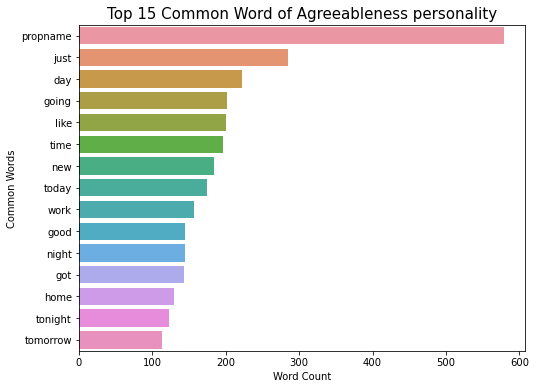

In [50]:
# Choose bar chart of Top 15 common word in status of Agreeableness personality
plt.figure(figsize = (8, 6))
sns.barplot(x= text_and_scores[text_and_scores["cAGR"]==1][cvec.get_feature_names_out()].sum().sort_values(ascending=False).head(15).values,\
                    y = text_and_scores[text_and_scores["cAGR"]==1][cvec.get_feature_names_out()].sum().sort_values(ascending=False).head(15).index)
plt.ylabel('Common Words')
plt.xlabel('Word Count')
plt.title("Top 15 Common Word of Agreeableness personality",size =15);

These are the most frequent words used by individuals who scored highly in the Agreeableness category. It makes sense that "propname" would rank highest because discussing other people is common. A high agreeableness rating would indicate that the person tends to win the support of others. Because they are posting about people who might have similar opinions to them on those topics, making them agreeable, it makes sense that "propname" would have such high status.